In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import random

class VAE(nn.Module):
    def __init__(self, fcd, ld, matsz, rank):
        super(VAE, self).__init__()
        self.fcd = fcd
        self.ld = ld
        self.matsz = matsz
        self.rank = rank
        self.enc1 = nn.Linear(fcd, 1000).float().cuda()
        self.enc2 = nn.Linear(1000, ld).float().cuda()
        self.dec1 = nn.Linear(ld+6, 1000).float().cuda()
        self.dec2 = nn.Linear(1000, matsz*rank).float().cuda()

    def enc(self, x):
        x = F.relu(self.enc1(x))
        z = self.enc2(x)
        return z

    def gen(self, n):
        return torch.randn(n, self.ld).float().cuda()/(10**0.5)

    def dec(self, z, age, sex, race, rest, nback, emoid):
        z = torch.cat([z, age.unsqueeze(1), sex.unsqueeze(1), race.unsqueeze(1), 
                       rest.unsqueeze(1), nback.unsqueeze(1), emoid.unsqueeze(1)], dim=1)
        x = F.relu(self.dec1(z))
        x = self.dec2(x)
        x = x.reshape(len(z), self.matsz, self.rank)
        x = torch.einsum('abc,adc->abd', x, x)
        return x

    def vectorize(self, x):
        a,b = np.triu_indices(self.matsz, 1)
        return x[:,a,b]

def rmse(a, b, mean=torch.mean):
    return mean((a-b)**2)**0.5

def pretty(x):
    return f'{round(float(x), 4)}'

pncvae = VAE(34716, 30, 264, 5)
pncvae.load_state_dict(torch.load('/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/vae_1000_z30_cov6_264_rank5.torch'))
pncvae.eval()

print('Done')

Done


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import random

class VAE2(nn.Module):
    def __init__(self, fcd, ld, matsz, rank):
        super(VAE2, self).__init__()
        self.fcd = fcd
        self.ld = ld
        self.matsz = matsz
        self.rank = rank
        self.enc1 = nn.Linear(fcd, 1000).float().cuda()
        self.enc2 = nn.Linear(1000, ld).float().cuda()
        self.dec1 = nn.Linear(ld+4, 1000).float().cuda()
        self.dec2 = nn.Linear(1000, matsz*rank).float().cuda()

    def enc(self, x):
        x = F.relu(self.enc1(x))
        z = self.enc2(x)
        return z

    def gen(self, n):
        return torch.randn(n, self.ld).float().cuda()/(10**0.5)
    
    def dec(self, z, age, sex, race, sz):
        z = torch.cat([z, age.unsqueeze(1), sex.unsqueeze(1), race.unsqueeze(1), sz.unsqueeze(1)], dim=1)
        x = F.relu(self.dec1(z))
        x = self.dec2(x)
        x = x.reshape(len(z), self.matsz, self.rank)
        x = torch.einsum('abc,adc->abd', x, x)
        return x

    def vectorize(self, x):
        a,b = np.triu_indices(self.matsz, 1)
        return x[:,a,b]

bsnipvae = VAE2(34716, 30, 264, 5)
bsnipvae.load_state_dict(torch.load('/home/anton/Documents/Tulane/Research/ImageNomer/data/BSNIP/vae_1000_z30_cov4_264_rank5.torch'))
bsnipvae.eval()

print('Done')

Done


In [3]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


In [4]:
import pickle
import numpy as np

# s1.0 = male probably

bsnipdir = '/home/anton/Documents/Tulane/Research/data-sav/anton/cohorts/BSNIP/'
demo = pickle.load(open(f'{bsnipdir}/demographics.pkl', 'rb'))

bfc = []
brace = []
bsex = []
bage = []
bsz = []

a,b = np.triu_indices(264,1)

for sub in demo['Age_cal']:
    diag = demo['DXGROUP_1'][sub]
    if diag not in ['SZP', 'NC']:
        continue
    ra = demo['Race'][sub]
    if ra not in ['AA', 'CA']:
        continue
    se = demo['sex'][sub]
    diag = diag == 'SZP'
    ra = ra == 'AA'
    se = se == 's1.0'
    ag = demo['Age_cal'][sub]
    p = np.load(f'{bsnipdir}/fc/{sub}_task-unk_fc.npy')
    p = remap(vec2mat(p))[a,b]
    bage.append(ag)
    bsex.append(se)
    brace.append(ra)
    bsz.append(diag)
    bfc.append(p)

bfc = np.stack(bfc)
brace = np.array(brace).astype('int')
bsex = np.array(bsex).astype('int')
bsz = np.array(bsz).astype('int')
bage = np.array(bage)

print(max(bage))
print(min(bage))
print(np.mean(bage))
print(np.std(bage))
bage = (bage-np.mean(bage))/np.std(bage)

print([a.shape for a in [bfc, bsz, brace, bsex, bage]])

64.0
15.0
36.92098765432099
12.335582538145621
[(405, 34716), (405,), (405,), (405,), (405,)]


In [5]:
import pickle
import numpy as np

pncdir = '/home/anton/Documents/Tulane/Research/data-sav/anton/cohorts/PNC/'
lowrankdir = '/home/anton/Documents/Tulane/Research/Work/ContrastiveLearning/PNC/Top10/'
pncdemo = pickle.load(open(f'{pncdir}/demographics.pkl', 'rb'))
no_snps_subs = pickle.load(open('/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/fc_subs_no_snps.pkl', 'rb'))

rest = []
nback = []
emoid = []
restmat = []
nbackmat = []
emoidmat = []
race = []
sex = []
age = []
subids = []

a,b = np.triu_indices(264,1)

for sub in pncdemo['age_at_cnb']:
    if sub in no_snps_subs:
        continue
    try:
        ra = pncdemo['Race'][sub]
        ag = pncdemo['age_at_cnb'][sub]
        se = pncdemo['Sex'][sub]
        if ra not in ['AA', 'EA']:
            continue
        ra = ra == 'AA'
        se = se == 'M'
        r = np.load(f'{lowrankdir}/{sub}_task-resttop10_fc.npy')
        n = np.load(f'{lowrankdir}/{sub}_task-nbacktop10_fc.npy')
        e = np.load(f'{lowrankdir}/{sub}_task-emoidtop10_fc.npy')
        r = remap(vec2mat(r))
        n = remap(vec2mat(n))
        e = remap(vec2mat(e))
        race.append(ra)
        sex.append(se)
        age.append(ag)
        rest.append(r[a,b])
        nback.append(n[a,b])
        emoid.append(e[a,b])
        restmat.append(r)
        nbackmat.append(n)
        emoidmat.append(e)
        subids.append(sub)
    except:
        pass

rest = np.stack(rest)
nback = np.stack(nback)
emoid = np.stack(emoid)
restmat = np.stack(restmat)
nbackmat = np.stack(nbackmat)
emoidmat = np.stack(emoidmat)
race = np.array(race).astype('int')
sex = np.array(sex).astype('int')
age = np.array(age)
age = (age-np.mean(age))/np.std(age)

print([a.shape for a in [rest, nback, emoid, restmat, nbackmat, emoidmat, race, sex, age]])

[(1155, 34716), (1155, 34716), (1155, 34716), (1155, 264, 264), (1155, 264, 264), (1155, 264, 264), (1155,), (1155,), (1155,)]


In [6]:
import numpy as np

# BSNIP

n = 1000

with torch.no_grad():
    ag = 0*torch.ones(n).float().cuda()
    sx = 1*torch.ones(n).float().cuda()
    rc = 0*torch.ones(n).float().cuda()
    ss = 0*torch.ones(n).float().cuda()
    z = bsnipvae.gen(n)
    y = bsnipvae.dec(z, ag, sx, rc, ss)
    y_hc = y.detach().cpu().numpy()
    y_hc = np.mean(y_hc, axis=0)

    ag = 0*torch.ones(n).float().cuda()
    sx = 1*torch.ones(n).float().cuda()
    rc = 0*torch.ones(n).float().cuda()
    ss = 1*torch.ones(n).float().cuda()
    z = bsnipvae.gen(n)
    y = bsnipvae.dec(z, ag, sx, rc, ss)
    y_sz = y.detach().cpu().numpy()
    y_sz = np.mean(y_sz, axis=0)

print(y_hc.shape)
print(y_sz.shape)

(264, 264)
(264, 264)


In [18]:
# PNC

n = 1000

with torch.no_grad():
    ag = -1*torch.ones(n).float().cuda()
    sx = 0*torch.ones(n).float().cuda()
    rc = 0*torch.ones(n).float().cuda()
    task = torch.ones(n).float().cuda()
    z = pncvae.gen(n)
    y = pncvae.dec(z, ag, sx, rc, task, 0*task, 0*task)
    y_young = y.detach().cpu().numpy()
    y_young = np.mean(y_young, axis=0)

    ag = 1*torch.ones(n).float().cuda()
    sx = 0*torch.ones(n).float().cuda()
    rc = 0*torch.ones(n).float().cuda()
    task = torch.ones(n).float().cuda()
    z = pncvae.gen(n)
    y = pncvae.dec(z, ag, sx, rc, task, 0*task, 0*task)
    y_old = y.detach().cpu().numpy()
    y_old = np.mean(y_old, axis=0)

    ag = 0*torch.ones(n).float().cuda()
    sx = 0*torch.ones(n).float().cuda()
    rc = 0*torch.ones(n).float().cuda()
    task = torch.ones(n).float().cuda()
    z = pncvae.gen(n)
    y = pncvae.dec(z, ag, sx, rc, task, 0*task, 0*task)
    y_mid = y.detach().cpu().numpy()
    y_mid = np.mean(y_mid, axis=0)

    ag = 0*torch.ones(n).float().cuda()
    sx = 1*torch.ones(n).float().cuda()
    rc = 0*torch.ones(n).float().cuda()
    task = torch.ones(n).float().cuda()
    z = pncvae.gen(n)
    y = pncvae.dec(z, ag, sx, rc, task, 0*task, 0*task)
    y_male = y.detach().cpu().numpy()
    y_male = np.mean(y_male, axis=0)

    ag = 0*torch.ones(n).float().cuda()
    sx = 0*torch.ones(n).float().cuda()
    rc = 0*torch.ones(n).float().cuda()
    task = torch.ones(n).float().cuda()
    z = pncvae.gen(n)
    y = pncvae.dec(z, ag, sx, rc, task, 0*task, 0*task)
    y_female = y.detach().cpu().numpy()
    y_female = np.mean(y_female, axis=0)

    ag = 0*torch.ones(n).float().cuda()
    sx = 1*torch.ones(n).float().cuda()
    rc = 1*torch.ones(n).float().cuda()
    task = torch.ones(n).float().cuda()
    z = pncvae.gen(n)
    y = pncvae.dec(z, ag, sx, rc, task, 0*task, 0*task)
    y_aa = y.detach().cpu().numpy()
    y_aa = np.mean(y_aa, axis=0)

    ag = 0*torch.ones(n).float().cuda()
    sx = 1*torch.ones(n).float().cuda()
    rc = 0*torch.ones(n).float().cuda()
    task = torch.ones(n).float().cuda()
    z = pncvae.gen(n)
    y = pncvae.dec(z, ag, sx, rc, task, 0*task, 0*task)
    y_ea = y.detach().cpu().numpy()
    y_ea = np.mean(y_ea, axis=0)

print(y_young.shape)
print(y_old.shape)
print(y_male.shape)
print(y_female.shape)
print(y_aa.shape)
print(y_ea.shape)

(264, 264)
(264, 264)
(264, 264)
(264, 264)
(264, 264)
(264, 264)


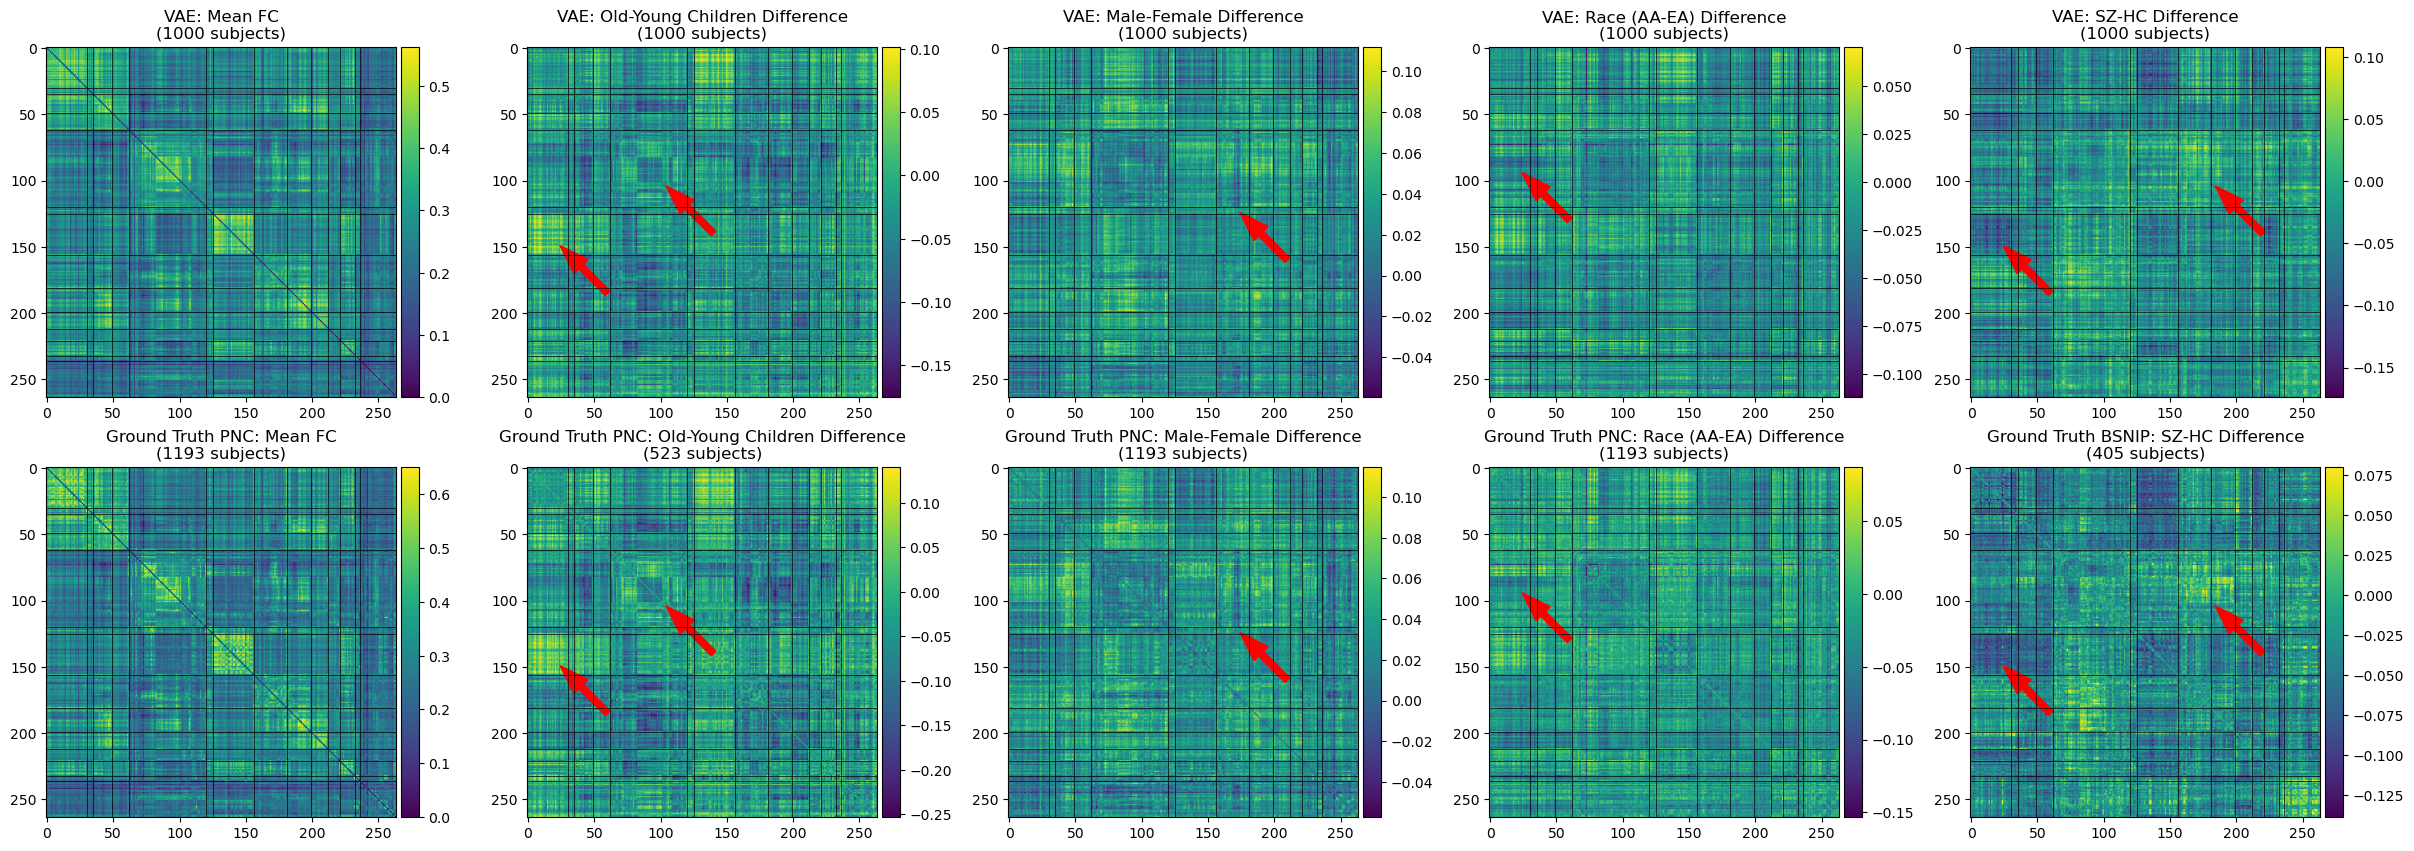

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

sz_hc_diff = np.mean(bfc[bsz == 1], axis=0) - np.mean(bfc[bsz == 0], axis=0)
sz_hc_diff = vec2mat(sz_hc_diff)
sz_hc_diff[sz_hc_diff > 0.08] = 0.08

fig, ax = plt.subplots(2,5,figsize=(30,10))

sz_hc_diff2 = y_sz-y_hc
# sz_hc_diff2[sz_hc_diff2 < -.13] = -.13

im = ax[0,4].imshow(sz_hc_diff2)

divider = make_axes_locatable(ax[0,4])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,4].imshow(sz_hc_diff)

divider = make_axes_locatable(ax[1,4])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(im, cax=cax, orientation='vertical')

avg = vec2mat(np.mean(rest, axis=0))
avg[avg > 0.65] = 0.65
avg_vae = y_young/3+y_mid/3+y_old/3
avg_vae = avg_vae * (1-np.eye(264))

im = ax[0,0].imshow(avg_vae)

divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,0].imshow(avg)

divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[0,1].imshow(y_old-y_young)

divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(im, cax=cax, orientation='vertical')

# print(np.sum(age >= 1)+np.sum(age <= -1))
diff_y_old = np.mean(rest[age >= 1], axis=0) - np.mean(rest[age <= -1], axis=0)
diff_y_old[diff_y_old > 0.14] = 0.14
diff_y_old = vec2mat(diff_y_old)

im = ax[1,1].imshow(diff_y_old)

divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[0,2].imshow(y_male-y_female)

divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(im, cax=cax, orientation='vertical')

diff_y_mf = np.mean(rest[sex == 1], axis=0) - np.mean(rest[sex == 0], axis=0)
diff_y_mf = vec2mat(diff_y_mf)

im = ax[1,2].imshow(diff_y_mf)

divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[0,3].imshow(y_aa-y_ea)

divider = make_axes_locatable(ax[0,3])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(im, cax=cax, orientation='vertical')

diff_y_aa_ea = np.mean(rest[race == 1], axis=0) - np.mean(rest[race == 0], axis=0)
diff_y_aa_ea = vec2mat(diff_y_aa_ea)

im = ax[1,3].imshow(diff_y_aa_ea)

divider = make_axes_locatable(ax[1,3])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(im, cax=cax, orientation='vertical')

bounds = [0, 30, 35, 49, 62, 120, 125, 156, 181, 199, 212, 221, 232, 236, 264]

for ax0 in ax:
    for axx in ax0:
        for a in bounds[1:-1]:
            axx.plot([a,a],[0,263], color='black', linewidth=0.5)
            axx.plot([0,263],[a,a], color='black', linewidth=0.5)

ax[0,0].set_title('VAE: Mean FC\n(1000 subjects)')
ax[1,0].set_title('Ground Truth PNC: Mean FC\n(1193 subjects)')

ax[0,1].set_title('VAE: Old-Young Children Difference\n(1000 subjects)')
ax[1,1].set_title('Ground Truth PNC: Old-Young Children Difference\n(523 subjects)')

ax[0,2].set_title('VAE: Male-Female Difference\n(1000 subjects)')
ax[1,2].set_title('Ground Truth PNC: Male-Female Difference\n(1193 subjects)')

ax[0,3].set_title('VAE: Race (AA-EA) Difference\n(1000 subjects)')
ax[1,3].set_title('Ground Truth PNC: Race (AA-EA) Difference\n(1193 subjects)')

ax[0,4].set_title('VAE: SZ-HC Difference\n(1000 subjects)')
ax[1,4].set_title('Ground Truth BSNIP: SZ-HC Difference\n(405 subjects)')

ax[0,1].arrow(60,185,-20,-20, width=5, color='red')
ax[1,1].arrow(60,185,-20,-20, width=5, color='red')

ax[0,1].arrow(140,140,-20,-20, width=5, color='red')
ax[1,1].arrow(140,140,-20,-20, width=5, color='red')

ax[0,2].arrow(210,160,-20,-20, width=5, color='red')
ax[1,2].arrow(210,160,-20,-20, width=5, color='red')

ax[0,3].arrow(60,130,-20,-20, width=5, color='red')
ax[1,3].arrow(60,130,-20,-20, width=5, color='red')

ax[0,4].arrow(60,185,-20,-20, width=5, color='red')
ax[1,4].arrow(60,185,-20,-20, width=5, color='red')

ax[0,4].arrow(220,140,-20,-20, width=5, color='red')
ax[1,4].arrow(220,140,-20,-20, width=5, color='red')

fig.show()
fig.savefig('/home/anton/Documents/Tulane/Research/Work/CL-VAE/VAE-ground-truth2.pdf')